In [137]:
from Module import *
from TrainAlgorithms import *
from keras.datasets import mnist
import time
from sklearn import preprocessing

In [138]:
path="../../../../Data/malware-classification/"
with open(path+'data11.npy', 'rb') as f:
    transxtrain=np.load(f)
    transx_test=np.load(f)
    transytrain=np.load(f)
    transy_test=np.load(f)
xtr=torch.from_numpy(transxtrain).float()
xte=torch.from_numpy(transx_test).float()
ytr=torch.from_numpy(transytrain).long()
yte=torch.from_numpy(transy_test).long()
scaler = preprocessing.Normalizer().fit(xtr)
x_tr = torch.tensor(scaler.transform(xtr))
x_te = torch.tensor(scaler.transform(xte))

In [139]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train=torch.from_numpy(x_train).float().reshape(60000,784)
x_test=torch.from_numpy(x_test).float().reshape(10000,784)
y_train=torch.from_numpy(y_train).long()
y_test=torch.from_numpy(y_test).long()
scaler = preprocessing.Normalizer().fit(x_train)
x_train = torch.tensor(scaler.transform(x_train))
x_test = torch.tensor(scaler.transform(x_test))

In [68]:
def binary(y_train, label):
    y_new=torch.ones((y_train.shape))
    for i in range(y_train.shape[0]):
        if y_train[i]==label:
            y_new[i]=0
        else:
            y_train[i]=1
    return y_new

In [134]:
model=HDCModel(9,257,2048)
# train_start(model,NeuralHDv2(15,4,4,.0001,.1),xtr,ytr)
# train_start(model,Normalize(),xtr,ytr)
# train_start(model,ClassicVersion2(1,.0001),xtr,binary(ytr,0).long())

In [135]:
eval_acc(model,xte,yte)

tensor(0.1399)

In [120]:
model.basis.shape

torch.Size([2048, 257])

In [124]:
full=model.encode(xtr)
def encode(model,xtr,i):
    n = xtr.size(0)
    h = torch.empty(n, model.basis[i:i+1].shape[0], device=xtr.device, dtype=xtr.dtype)
    temp = torch.empty(n, model.basis[i:i+1].shape[0], device=xtr.device, dtype=xtr.dtype)

    # we need batches to remove memory usage
    for j in range(0, n, n):
        torch.matmul(xtr[j:j+n], model.basis[i:i+1].T, out=temp)

        # self.noise ... I haven't seen any indication that it works better 
        # if self.noise:
        torch.add(temp, model.base, out=h[j:j+n])#h[i:i+bsize]=temp# torch.add(temp, self.base, out=h[i:i+bsize])
        # else:
        # h[i:i+bsize]=temp
        h[j:j+n].cos_().mul_(temp.sin_())
    return h
accs=torch.zeros((model.dimensionality,))
for i in range(0,model.dimensionality):
    yhat=cos_cdist(encode(model,xtr,i), model.classes[:,i:i+1]).argmax(1)#full[:,i:i+1]
    eval=[yhat[i]==yte[i] for i in range(len(yte))]
    accs[i]=sum(eval)/len(yte)

<ipython-input-124-bdd91d1510ba>:13: UserWarning: An output with one or more elements was resized since it had shape [8151, 1], which does not match the required output shape [8151, 2048].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:23.)
  torch.add(temp, model.base, out=h[j:j+n])#h[i:i+bsize]=temp# torch.add(temp, self.base, out=h[i:i+bsize])


In [125]:
accs

tensor([0.1399, 0.1399, 0.1399,  ..., 0.1399, 0.1399, 0.1399])

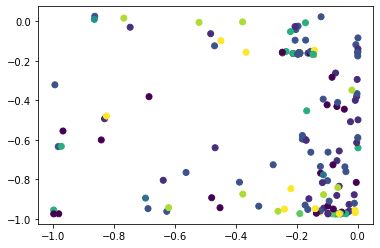

In [141]:
normed_classes=torch.nn.functional.normalize(model.classes)
var = torch.var(normed_classes, 0) 
# assert len(var) == self.dimensionality
# rank each entry in variances from smallest to largest
order = torch.argsort(accs)
x=model.encode(xtr[:200])[:,order[0]]
y=model.encode(xtr[:200])[:,order[1]]
plt.scatter(x,y,c=yte[:200])

In [76]:
model.basis

tensor([0.0593, 0.0626, 0.0626,  ..., 0.2083, 0.2102, 0.2109])
